# Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
df.timestamp.max(), df.timestamp.min()

('2017-01-24 13:41:54.460509', '2017-01-02 13:42:05.378582')

b. Use the below cell to find the number of rows in the dataset.

In [4]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [5]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [6]:
conv_prop = df[df['converted'] == 1].count()[0]/df.shape[0]
conv_prop

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [7]:
 df.query('group == "treatment" and not landing_page == "new_page"').count()[0] + df.query('group != "treatment" and landing_page == "new_page"').count()[0] 

3893

f. Do any of the rows have missing values?

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


**There are no rows with missing values.**

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. 

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
df1 = df.query('(group == "treatment" and not landing_page == "new_page") or (group != "treatment" and landing_page == "new_page")')
index = df1.index
df2 = df.drop(index)

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.`

a. How many unique **user_id**s are in **df2**?

In [11]:
df2.user_id.count()

290585

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2.user_id.duplicated().sum()

1

c. What is the row information for the repeat **user_id**? 

In [13]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [14]:
df2.query('group == "treatment"').count()[0]

145311

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [15]:
df2.drop_duplicates("user_id",inplace=True)

`4.` 

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
p_overall = df2[df2['converted'] == 1].count()[0]/df2.shape[0]
p_overall

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
pconv_old = df2.query('group == "control" and converted == 1').count()[0]/df2[df2['group'] == "control"].shape[0]
pconv_old

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
pconv_new = df2.query('group == "treatment" and converted == 1').count()[0]/df2[df2['group'] == "treatment"].shape[0]
pconv_new

0.11880806551510564

In [19]:
obs_diff = pconv_new - pconv_old
obs_diff

-0.0015782389853555567

d. What is the probability that an individual received the new page?

In [20]:
df2[df2['landing_page'] == "new_page"].shape[0]/df2.shape[0]

0.5000619442226688

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

**There is no clue that either the users in the 'control' or 'treatment' group were converted more frequently than the other. Only 12.0% of the users in the 'control' group were lead to a conversions while, for the users in the 'treatment' group, it's only the 11.8% of them. So, looking at the results we just got, we can see that there's a 50% chance for a conversion regardless of the page. **

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**$$H_0 : p_{new} - p_{old} \leq 0$$ 
$$H_1 : p_{new} - p_{old} > 0$$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>


a. What is the **convert rate** for $p_{new}$ under the null? 

In [21]:
p_new = p_overall
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [22]:
p_old = p_overall
p_old

0.11959708724499628

c. What is $n_{new}$?

In [23]:
n_new = df2.query('group == "treatment"').count()[0]
n_new

145310

d. What is $n_{old}$?

In [24]:
n_old = df2.query('group == "control"').count()[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:
new_page_converted = np.random.binomial(n_new, p_new)
new_page_converted

17575

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
old_page_converted = np.random.binomial(n_old, p_old)
old_page_converted

17487

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [27]:
psim_new = new_page_converted/n_new
psim_old = old_page_converted/n_old

sim_diff = psim_new-psim_old
sim_diff

0.00057577997834400152

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [28]:
p_diffs=[]
for _ in range(10000):
    new_page_converted = np.random.binomial(n_new, p_new)
    old_page_converted = np.random.binomial(n_old, p_old)
    psim_new = new_page_converted/n_new
    psim_old = old_page_converted/n_old
    p_diffs.append(psim_new-psim_old)


i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

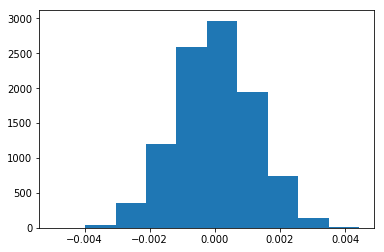

In [29]:
diffs = np.array(p_diffs)
plt.hist(diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [30]:
(p_diffs > obs_diff).mean()

0.90790000000000004

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The value we've just computed is called 'p-value'. This value is the probability of observing our statistic or a more extreme statistic from the null hypothesis. It tells us if the new data we simulated is usable or, as in this case, the 90.8% is data that has been simulated but cannot be used because they fall in the null values.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [31]:
import statsmodels.api as sm

convert_old = df2.query('group == "control" and converted == 1').count()[0]
convert_new = df2.query('group == "treatment" and converted == 1').count()[0]
n_old = n_old
n_new = n_new

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [32]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative = 'larger')
z_score, p_value

(-1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The z-score is a measure of how many standard deviations below or above the population mean a raw score is, while the p-value agrees with the p-value computed in question j. **

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [33]:
df2[['treatment','ab_page']] = pd.get_dummies(df2['group'])
df2.drop(['treatment'], axis=1, inplace=True)
df2['intercept'] = 1
df2.head()


,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [34]:
logm = sm.Logit(df2['converted'], df2[['intercept','ab_page']])

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [35]:
results = logm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 19 Jun 2018   Pseudo R-squ.:               8.077e-06
Time:                        15:16:59   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br> 

**The p-value associated with 'ab_page' is 0.190, is different from the one we computed before because the nature of a regression test is not concerned with which had a positive or negative change, specifically. It is concerned with if the condition had any effect at all, so a two-tailed test.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Yes, there are some disadvantages in adding additional terms into the model because we then increase the probability to find some data that changes our results significantly but they're false positives. It is a good idea though to examine other factors in order to be able to build a more precise model for our predictions. To alleviate the problem just mentioned we can use some corrections, like the Bonferroni correction, to eliminate the false positives.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 


In [36]:
df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [37]:
df_countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 2 columns):
user_id    290584 non-null int64
country    290584 non-null object
dtypes: int64(1), object(1)
memory usage: 4.4+ MB


In [38]:
df2 = df2.set_index('user_id').join(df_countries.set_index('user_id'))
df2.reset_index(inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US


In [39]:
df2.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [40]:
df2[['CA','UK','US']] = pd.get_dummies(df2.country)
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US,0,0,1


In [41]:
df2.drop(['CA'],axis=1, inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US,0,1


In [42]:
logm2 = sm.Logit(df2['converted'], df2[['intercept','UK','US']])
results2 = logm2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Tue, 19 Jun 2018   Pseudo R-squ.:               1.521e-05
Time:                        15:17:01   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

Does it appear that country had an impact on conversion?  
**Apparently neither the UK or US users seem to have an impact on the conversion value.** 

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [43]:
logm3 = sm.Logit(df2['ab_page'], df2[['intercept','converted','UK','US']])
results2 = logm3.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.825077
         Iterations 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                ab_page   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 19 Jun 2018   Pseudo R-squ.:                 -0.2178
Time:                        15:17:01   Log-Likelihood:            -2.3975e+05
converged:                       True   LL-Null:                   -1.9688e+05
                                        LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0159      0.017      0.956      0.339      -0.017       0.049
converted     -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK            -0.0211      0.018     -1.162      0.245      -0.057       0.015
US            -0.0123      0.017     -0.716      0.474      -0.046       0.021
==============================================================================
"""

<a id='conclusions'></a>
## Conclusions

Looking at all the data we collected and analyzed the conclusion is that it **fails to reject the null** hypothesis. We can come to this conclusion because in each model we computed we don't find any correlation between the conversion rate and the different landing page because the p-value is always higher than expected. 

Maybe by extending the duration of the test we could gather more significant data.

In [44]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0